<a href="https://colab.research.google.com/github/kayjew/ENPH353_Lab5/blob/main/ENPH353_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
#used to create tensors
import torch
%matplotlib inLine

In [230]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    #gradient starts off as zero
    self.grad = 0.0
    #defines chain rules for calculating derivative in back propogation
    self._backward = lambda: None
    #creates an empty set of children that inherit this data structure
    self._prev = set(_children)
    #stores a string of operation that act on the children of the expression
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  #addition of 2 value objects
  def __add__(self, other):
    #allows us to wrap integers in a Value
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    #defines the derivative under addition using chain rule
    def _backward():
      #note that the plus equals here solve the multivariable chain rule issue (variable is used mroe than once)
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  #multiply 2 value objects
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    #defines the derivative under multiplicaiton using chain rule
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  #raises numbers to the power of (used in division)
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  #if an int._mul_ cannot be called, it reorganizes the equation to do integer multiplication
  def __rmul__(self, other): # other can only be int or float
    return self * other

  #rewrites division and multiplication by inverse (using pow)
  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  #subtracts a value and value/int using addition of negation
  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  #tan of value objects
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    #defines the derivative under tan using chain rule
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  #defines derivatives and values for e^x
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  #calculates the backpropogation for any functions previously defined using topological sort
  def backward(self):

    #topological sort
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [231]:
from graphviz import Digraph
#takes in L and draws a CNN diagram for it, where square boxes represent chidlren and oval boxes represent ops
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [232]:
class Neuron:

  def __init__(self, nin):
    #weight
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    #bias
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #zip takes to iterators and create and iterator for their tuples
    out = 2*act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  #creates a list of neurons, with nout beign the number of neurons in the layer
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  #nouts deifnes the sizes of all layers in our mlp
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [233]:
loss_history = []
w_history = []
b_history = []

xs = [[2],[3],[4]]
ys = [2,1,-2]
nn = MLP(1,[1])

y_pred = [nn(x) for x in xs]
y_pred

[Value(data=-1.774780058183467),
 Value(data=-1.9126612326522456),
 Value(data=-1.966871440069963)]

In [234]:
for k in range(300):
  #forward pass
  y_pred = [nn(a) for a in xs]
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, y_pred))

  #backward pass
  for p in nn.parameters():
    p.grad = 0.0
  loss.backward()

  #update
  for p in nn.parameters():
    #the value in front of p grad is the learning rate
    p.data += -.02*p.grad

  loss_history.append(loss.data)
  w_history.append(nn.layers[0].neurons[0].w[0].data)
  b_history.append(nn.layers[0].neurons[0].b.data)

In [235]:
y_pred

[Value(data=1.9400133999791116),
 Value(data=0.8404952860368894),
 Value(data=-1.6651209577435617)]

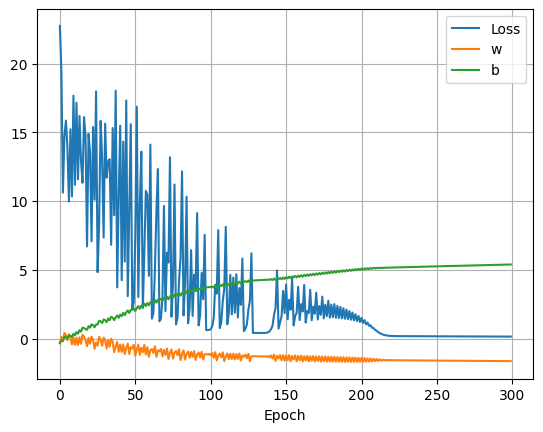

In [236]:
plt.figure()
plt.plot(loss_history, label="Loss")
plt.plot(w_history, label="w")
plt.plot(b_history, label="b")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.show()